# Control arm

In [1]:
import numpy as np
import pandas as pd
import pyvista as pv
import deepxde as dde

from pinnDSE.geom import MeshGeom
from pinnDSE.viz import *
from pinnDSE.elasticity import *
from pinnDSE.bc import *

Using TensorFlow 2 backend.

Instructions for updating:
non-resource variables are not supported in the long term


2 read mesh: 0.009970664978027344


3 coordinate transform: 4.429239511489868
2 read results: 6.112724304199219
1 total mesh and result loading: 6.312227487564087
1 total edge processing: 0.41691136360168457


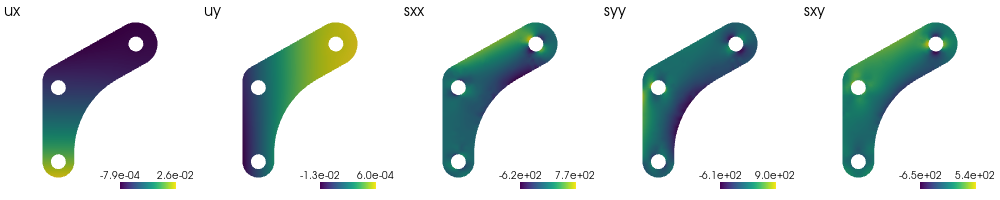

In [2]:
# load mesh and solver results
op2File = 'data/controlArm/v2.0/controlArm02.op2'
geom = MeshGeom(op2File, thickness=1.0)
plotScalarFields(geom.mesh, geom.resDf)

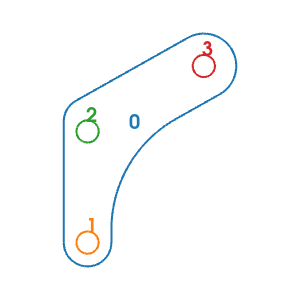

In [3]:
drawBoundaries(geom.bndDict)

Compiling model...
Building feed-forward neural network...
'build' took 0.052826 s

'compile' took 1.200756 s

Initializing variables...
Training model...

Step      Train loss                                                                                                                            Test loss                                                                                                                             Test metric
0         [1.38e+03, 3.68e+02, 7.71e+03, 9.47e+05, 3.33e+04, 6.45e-08, 2.96e-07, 1.25e+02, 1.24e+02, 5.27e+03, 3.09e+02, 4.56e+03, 2.53e+01]    [1.42e+03, 3.87e+02, 7.59e+03, 9.78e+05, 3.31e+04, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00]    []  

Best model at step 0:
  train loss: 1.00e+06
  test loss: 1.02e+06
  test metric: []

'train' took 1.007307 s

Compiling model...
'compile' took 0.865682 s

Initializing variables...
Training model...

Step      Train loss                                                

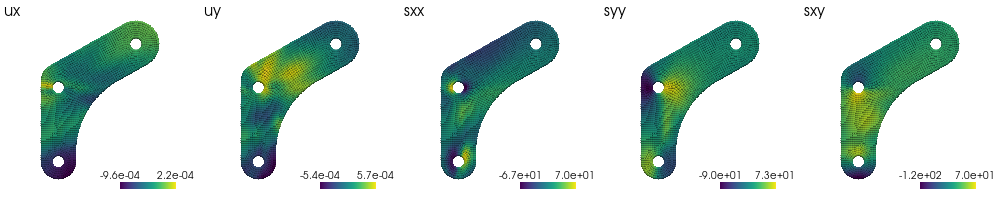

In [16]:
# supports
xBc = SupportBC(geom, bndId=3, U=0, component=0)
yBc = SupportBC(geom, bndId=3, U=0, component=1)

# traction free edges
xTr0 = TractionBC(geom, bndId=0, T=0, component=0)
yTr0 = TractionBC(geom, bndId=0, T=0, component=1)

# external loads
xTr1 = TractionBC(geom, bndId=1, T=34/geom.bndAreaDict[1], component=0)
yTr1 = TractionBC(geom, bndId=1, T=0, component=1)

xTr2 = TractionBC(geom, bndId=2, T=-34/geom.bndAreaDict[2], component=0)
yTr2 = TractionBC(geom, bndId=2, T=0, component=1)

# problem setup
bndNumSamplesDir = {0:800, 1:200, 2:200, 3:200}
paramDict = {'E':2.1e5, 'nu':0.3}
bcList = [xBc,yBc,xTr0,yTr0,xTr1,yTr1,xTr2,yTr2]
data = StrctPDE(geom, 
            elasticityEqs, 
            bcList, 
            num_domain=1000, 
            num_boundary_dir=bndNumSamplesDir, 
            num_test=500,
            paramDict=paramDict)

for bc in bcList:
    if isinstance(bc, TractionBC): 
        bc.train_n = data.train_n

# build model
net = dde.maps.FNN([2] + [64]*4  + [5], "tanh", "Glorot uniform")
outScales = np.array([1e-2, 1e-2, 1e2, 1e2, 1e2]) # [ux,uy,sxx,syy,sxy]
net.apply_output_transform(lambda x,y : y*outScales) 
model = dde.Model(data, net)

# get the unweighted loss values
model.compile("adam", lr=0.001)
losshistory, train_state = model.train(epochs=0)
lw = losshistory.loss_train[0]**(-1) 
lw[9] *= 1000
lw[11] *= 1000

# train
model.compile("adam", lr=0.001, loss_weights=lw)
losshistory, train_state = model.train(epochs=1000, display_every=100)

pred = model.predict(geom.mesh.points[:,:2])
predDf = pd.DataFrame(pred, columns=['ux', 'uy', 'sxx', 'syy', 'sxy'])
pc = pv.PolyData(geom.mesh.points)
plotScalarFields(pc, predDf)

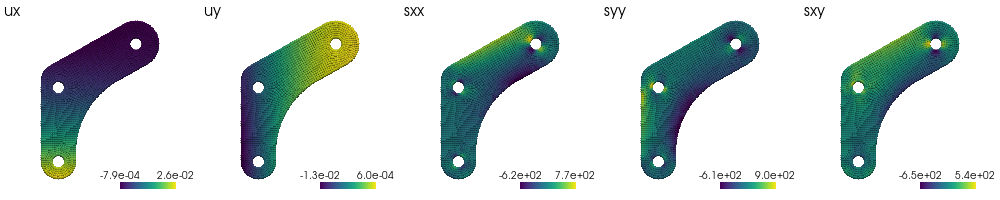

In [5]:
plotScalarFields(pc, geom.resDf)

In [17]:
bcNames = ['xBc','yBc','xTr0','yTr0','xTr1','yTr1','xTr2','yTr2']
# lines = alt.Chart(pd.DataFrame({'step':[1000,3000,4000]})).mark_rule(color='gray').encode(x='step:Q')
lossPlot(losshistory, bcNames)

alt.Chart(...)

Compiling model...
'compile' took 1.005346 s

Training model...

Step      Train loss                                                                                                                            Test loss                                                                                                                             Test metric
1000      [1.15e+03, 7.77e+01, 1.32e+01, 1.77e+00, 4.68e-01, 9.75e-03, 4.73e-03, 9.60e+00, 6.69e+00, 1.05e+00, 2.12e-02, 2.09e+01, 6.56e+02]    [4.97e+02, 7.38e+01, 1.61e+01, 1.70e+00, 4.52e-01, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00]    []  
1100      [6.90e+02, 8.70e+01, 1.74e+01, 2.59e+00, 5.51e-01, 2.24e-03, 4.96e-03, 7.01e+00, 5.39e+00, 9.92e-01, 1.88e-01, 2.38e+01, 6.49e+02]    [3.42e+02, 7.94e+01, 2.09e+01, 2.37e+00, 3.94e-01, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00]    []  
1200      [4.61e+02, 6.91e+01, 1.55e+01, 2.33e+00, 5.75e-01, 6.04e-04, 5.83e-04

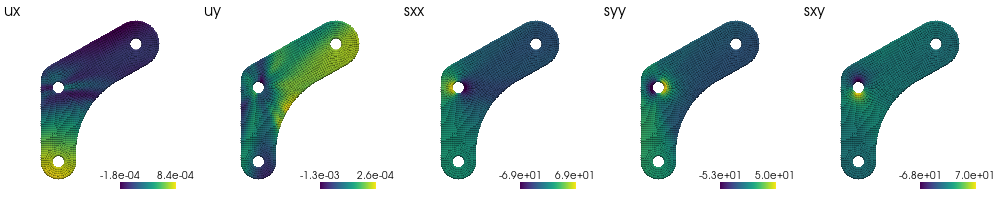

In [6]:
model.compile("adam", lr=0.001, loss_weights=lw)
losshistory, train_state = model.train(epochs=1000, display_every=100)

pred = model.predict(geom.mesh.points[:,:2])
predDf = pd.DataFrame(pred, columns=['ux', 'uy', 'sxx', 'syy', 'sxy'])
pc = pv.PolyData(geom.mesh.points)
plotScalarFields(pc, predDf)

Compiling model...
'compile' took 0.844740 s

Training model...

Step      Train loss                                                                                                                            Test loss                                                                                                                             Test metric
1000      [8.39e+01, 2.66e+00, 1.71e+00, 8.74e-02, 5.45e-01, 1.68e-01, 4.03e-03, 6.22e+00, 1.22e+00, 2.06e+01, 1.71e-01, 1.07e+00, 9.86e-01]    [3.73e+01, 3.11e+00, 2.38e+00, 8.77e-02, 5.21e-01, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00]    []  
1100      [8.06e+01, 2.78e+00, 9.90e-01, 1.09e-01, 5.98e-01, 8.59e-03, 4.11e-03, 5.97e+00, 1.11e+00, 1.72e+01, 1.34e-01, 7.44e-01, 1.01e+00]    [3.41e+01, 3.16e+00, 1.55e+00, 1.10e-01, 5.92e-01, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00]    []  
1200      [7.05e+01, 2.80e+00, 1.04e+00, 1.16e-01, 7.07e-01, 9.35e-03, 3.14e-03

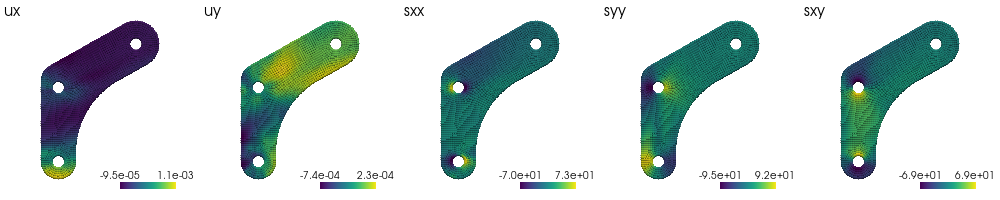

In [18]:
model.compile("adam", lr=0.001, loss_weights=lw)
losshistory, train_state = model.train(epochs=1000, display_every=100)

pred = model.predict(geom.mesh.points[:,:2])
predDf = pd.DataFrame(pred, columns=['ux', 'uy', 'sxx', 'syy', 'sxy'])
pc = pv.PolyData(geom.mesh.points)
plotScalarFields(pc, predDf)

In [19]:
bcNames = ['xBc','yBc','xTr0','yTr0','xTr1','yTr1','xTr2','yTr2']
# lines = alt.Chart(pd.DataFrame({'step':[1000,3000,4000]})).mark_rule(color='gray').encode(x='step:Q')
lossPlot(losshistory, bcNames)

alt.Chart(...)

Compiling model...
'compile' took 0.780911 s

Training model...

Step      Train loss                                                                                                                            Test loss                                                                                                                             Test metric
2000      [5.89e+00, 9.34e-01, 4.05e-01, 1.17e-01, 3.10e-01, 4.73e-04, 3.33e-04, 1.26e+00, 4.93e-01, 3.85e-01, 5.84e-01, 2.39e-01, 7.73e-01]    [5.43e+00, 1.09e+00, 5.40e-01, 7.96e-02, 2.34e-01, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00]    []  
2100      [2.15e+00, 4.54e-01, 2.91e-01, 8.24e-02, 1.56e-01, 3.37e-04, 1.44e-03, 1.21e+00, 2.90e-01, 1.57e-01, 3.67e-01, 9.43e-02, 7.52e-01]                                                                                                                                              
2200      [1.15e+00, 2.96e-01, 1.16e-01, 4.06e-02, 8.48e-02, 2.29e-04, 9.83e-05

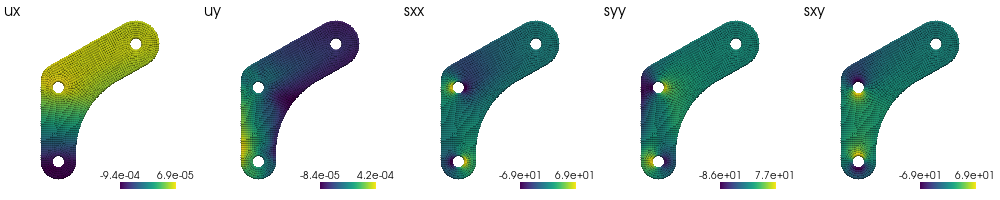

In [20]:
model.compile("L-BFGS-B", loss_weights=lw)
model.train_op.optimizer_kwargs['options']['maxiter']=1000
model.train_op.optimizer_kwargs['options']['maxfun']=1000
losshistory, train_state = model.train(display_every=100)

pred = model.predict(geom.mesh.points[:,:2])
predDf = pd.DataFrame(pred, columns=['ux', 'uy', 'sxx', 'syy', 'sxy'])
pc = pv.PolyData(geom.mesh.points)
plotScalarFields(pc, predDf)

In [21]:
lossPlot(losshistory, bcNames)

alt.Chart(...)

Compiling model...
'compile' took 0.804877 s

Training model...

Step      Train loss                                                                                                                            Test loss                                                                                                                             Test metric
3001      [5.36e-01, 5.42e-02, 1.20e-02, 5.87e-03, 8.71e-03, 4.97e-05, 2.01e-04, 9.97e-01, 2.06e-01, 2.03e-02, 5.53e-02, 3.69e-02, 6.39e-01]    [1.20e+00, 1.03e-01, 2.08e-02, 4.34e-03, 1.03e-02, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00]    []  
3100      [5.25e-01, 4.89e-02, 8.99e-03, 4.26e-03, 7.00e-03, 4.86e-05, 9.34e-05, 1.00e+00, 2.04e-01, 1.94e-02, 5.61e-02, 3.50e-02, 6.38e-01]                                                                                                                                              
3200      [5.20e-01, 4.63e-02, 8.14e-03, 2.91e-03, 6.15e-03, 8.89e-05, 8.93e-05

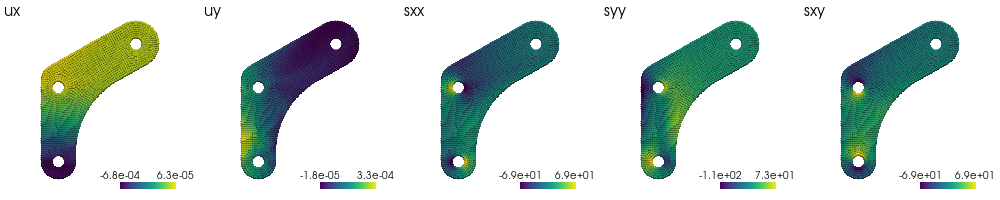

In [22]:
model.compile("L-BFGS-B", loss_weights=lw)
model.train_op.optimizer_kwargs['options']['maxiter']=1000
model.train_op.optimizer_kwargs['options']['maxfun']=1000
losshistory, train_state = model.train(display_every=100)

pred = model.predict(geom.mesh.points[:,:2])
predDf = pd.DataFrame(pred, columns=['ux', 'uy', 'sxx', 'syy', 'sxy'])
pc = pv.PolyData(geom.mesh.points)
plotScalarFields(pc, predDf)

In [23]:
lossPlot(losshistory, bcNames)

alt.Chart(...)

Compiling model...
'compile' took 0.885631 s

Training model...

Step      Train loss                                                                                                                            Test loss                                                                                                                             Test metric
4002      [4.32e-01, 5.55e-02, 1.09e-02, 3.39e-03, 7.91e-03, 5.04e-05, 8.45e-05, 9.46e-01, 1.87e-01, 1.89e-02, 5.59e-02, 2.34e-02, 5.51e-01]    [1.01e+00, 1.17e-01, 1.99e-02, 2.69e-03, 1.06e-02, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00]    []  
4100      [4.53e-01, 6.62e-02, 1.97e-02, 4.28e-03, 8.83e-03, 1.16e-04, 1.94e-04, 9.37e-01, 1.91e-01, 2.32e-02, 5.65e-02, 4.17e-02, 5.53e-01]    [1.03e+00, 1.32e-01, 3.12e-02, 3.39e-03, 1.06e-02, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00]    []  
4200      [4.35e-01, 5.74e-02, 1.06e-02, 3.72e-03, 7.98e-03, 7.25e-05, 1.04e-04

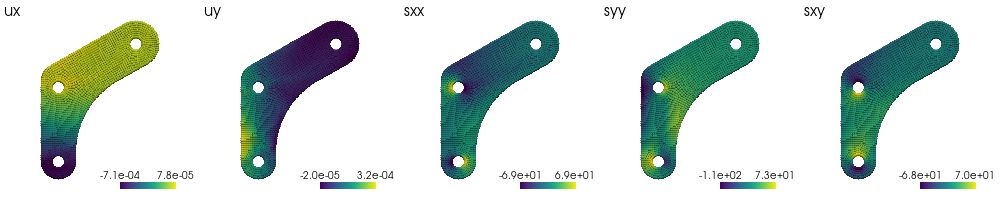

In [24]:
model.compile("adam", lr=0.001, loss_weights=lw)
losshistory, train_state = model.train(epochs=1000, display_every=100)

pred = model.predict(geom.mesh.points[:,:2])
predDf = pd.DataFrame(pred, columns=['ux', 'uy', 'sxx', 'syy', 'sxy'])
pc = pv.PolyData(geom.mesh.points)
plotScalarFields(pc, predDf)

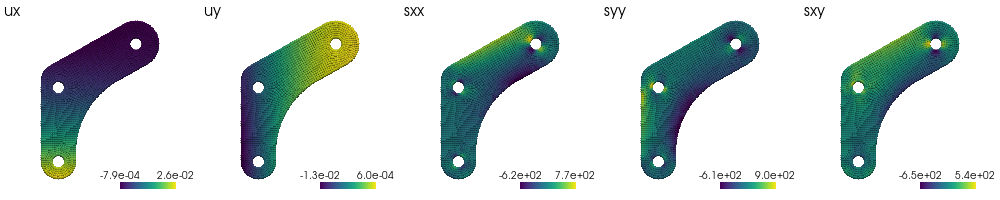

In [31]:
plotScalarFields(pc, geom.resDf)

In [30]:
lossPlot(losshistory, bcNames, scaleType='log', dropFirstStep=True)

alt.Chart(...)

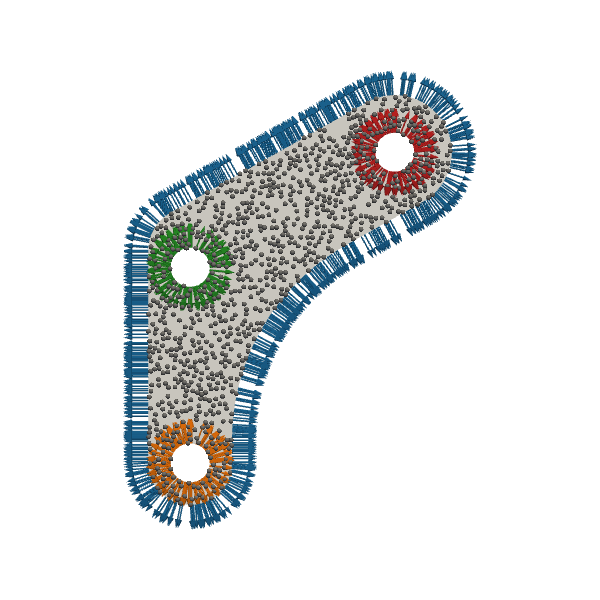

In [32]:
plotter = pv.Plotter(border=False)
plotter.set_background('white')
plotter.add_mesh(geom.mesh, show_edges=False)

# domain samples
pc = pv.PolyData(addZ(data.domainSamples))
plotter.add_mesh(pc, render_points_as_spheres=True, color='gray')

# boundary samples
colors = ['red', 'green', 'blue', 'yellow', 'purple', 'pink']
for bndId, color in zip(geom.bndDict.keys(), CATEGORY10):
    samples = addZ(data.bndSampleDict[bndId])
    normals = addZ(data.bndNormalsDict[bndId])
    plotter.add_arrows(samples, normals, 0.1, color=color)
plotter.show(window_size=(600,600), cpos='xy');